In [4]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



import seaborn as sns
import itertools
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline



In [5]:
fd_fake = pd.read_csv('Fake.csv')
fd_true = pd.read_csv('True.csv')

In [6]:
print(fd_fake.head(10))

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   
5   Racist Alabama Cops Brutalize Black Boy While...   
6   Fresh Off The Golf Course, Trump Lashes Out A...   
7   Trump Said Some INSANELY Racist Stuff Inside ...   
8   Former CIA Director Slams Trump Over UN Bully...   
9   WATCH: Brand-New Pro-Trump Ad Features So Muc...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

In [7]:
fd_fake.head(10)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017"
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017"
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017"
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017"


In [11]:
# Add a 'class' column for original classification (if needed later)
fd_fake["class"] = 0
fd_true["class"] = 1

In [12]:
# Combine the datasets for clustering
fd_margin = pd.concat([fd_fake, fd_true], axis=0)

In [15]:
# Drop the unnecessary columns and remove 'class' as we are doing unsupervised clustering
fd_margin = fd_margin.applymap(lambda x: x.lower() if isinstance(x, str) else x)
print(fd_margin.head())

C:\Users\Hp\AppData\Local\Temp\ipykernel_9660\711247738.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fd_margin = fd_margin.applymap(lambda x: x.lower() if isinstance(x, str) else x)


                                               title  \
0   donald trump sends out embarrassing new year’...   
1   drunk bragging trump staffer started russian ...   
2   sheriff david clarke becomes an internet joke...   
3   trump is so obsessed he even has obama’s name...   
4   pope francis just called out donald trump dur...   

                                                text subject  \
0  donald trump just couldn t wish all americans ...    news   
1  house intelligence committee chairman devin nu...    news   
2  on friday, it was revealed that former milwauk...    news   
3  on christmas day, donald trump announced that ...    news   
4  pope francis used his annual christmas day mes...    news   

                date  class  
0  december 31, 2017      0  
1  december 31, 2017      0  
2  december 30, 2017      0  
3  december 29, 2017      0  
4  december 25, 2017      0  


In [16]:
fd_margin.drop(["title"], axis=1,inplace=True)
fd_margin.head(16)

,text,subject,date,class
0,donald trump just couldn t wish all americans ...,news,"december 31, 2017",0
1,house intelligence committee chairman devin nu...,news,"december 31, 2017",0
2,"on friday, it was revealed that former milwauk...",news,"december 30, 2017",0
3,"on christmas day, donald trump announced that ...",news,"december 29, 2017",0
4,pope francis used his annual christmas day mes...,news,"december 25, 2017",0
5,the number of cases of cops brutalizing and ki...,news,"december 25, 2017",0
6,donald trump spent a good portion of his day a...,news,"december 23, 2017",0
7,in the wake of yet another court decision that...,news,"december 23, 2017",0
8,many people have raised the alarm regarding th...,news,"december 22, 2017",0
9,just when you might have thought we d get a br...,news,"december 21, 2017",0


In [9]:
def wordopt(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text inside square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', ' ', text)  # Remove newlines (replace with space)
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters (retain only alphabetic characters)
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [10]:
fd_margin.head()

,text,subject,date,class
0,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [3]:
lower_text = fd_margin.lower()
print(lower_text)

NameError: name 'fd_margin' is not defined

In [22]:
print(fd["text"].head(15))

0     Donald Trump just couldn t wish all Americans ...
1     House Intelligence Committee Chairman Devin Nu...
2     On Friday, it was revealed that former Milwauk...
3     On Christmas day, Donald Trump announced that ...
4     Pope Francis used his annual Christmas Day mes...
5     The number of cases of cops brutalizing and ki...
6     Donald Trump spent a good portion of his day a...
7     In the wake of yet another court decision that...
8     Many people have raised the alarm regarding th...
9     Just when you might have thought we d get a br...
10    A centerpiece of Donald Trump s campaign, and ...
11    Republicans are working overtime trying to sel...
12    Republicans have had seven years to come up wi...
13    The media has been talking all day about Trump...
14    Abigail Disney is an heiress with brass ovarie...
Name: text, dtype: object


In [12]:
fd['cleaned_text_length'] = fd['text'].apply(len)

In [13]:
# View the first few rows to check the lengths
print(fd[['text', 'cleaned_text_length']].head())

                                                text  cleaned_text_length
0  Donald Trump just couldn t wish all Americans ...                 2893
1  House Intelligence Committee Chairman Devin Nu...                 1898
2  On Friday, it was revealed that former Milwauk...                 3597
3  On Christmas day, Donald Trump announced that ...                 2774
4  Pope Francis used his annual Christmas Day mes...                 2346


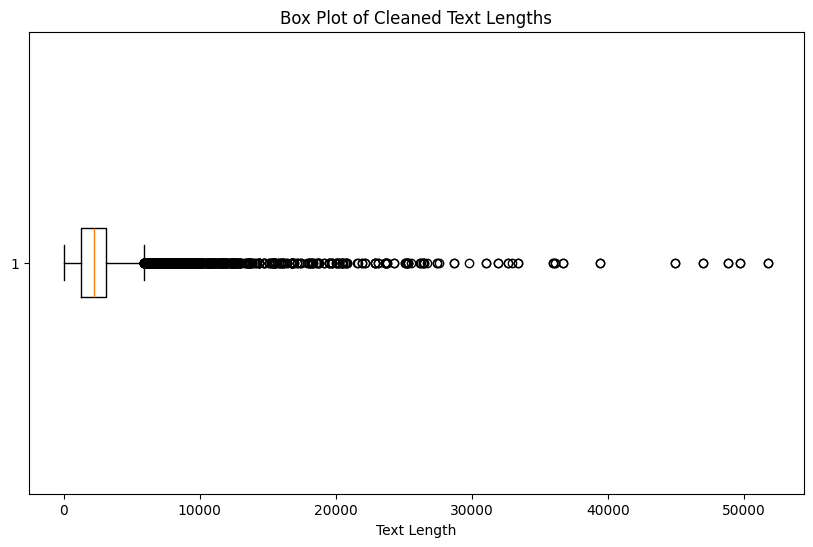

In [14]:
# ---- Draw Box Plot ----
plt.figure(figsize=(10, 6))
plt.boxplot(fd['cleaned_text_length'], vert=False)
plt.title('Box Plot of Cleaned Text Lengths')
plt.xlabel('Text Length')
plt.show()

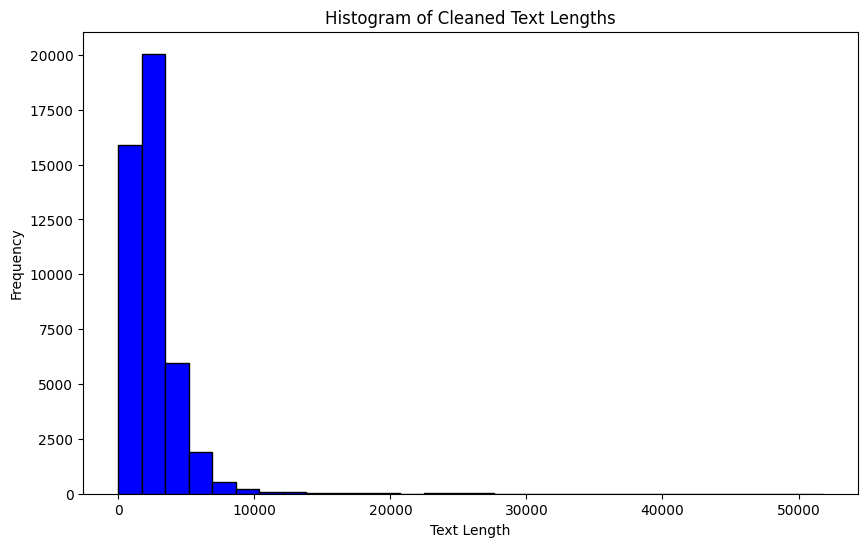

In [15]:
# ---- Draw Histogram ----
plt.figure(figsize=(10, 6))
plt.hist(fd['cleaned_text_length'], bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Cleaned Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

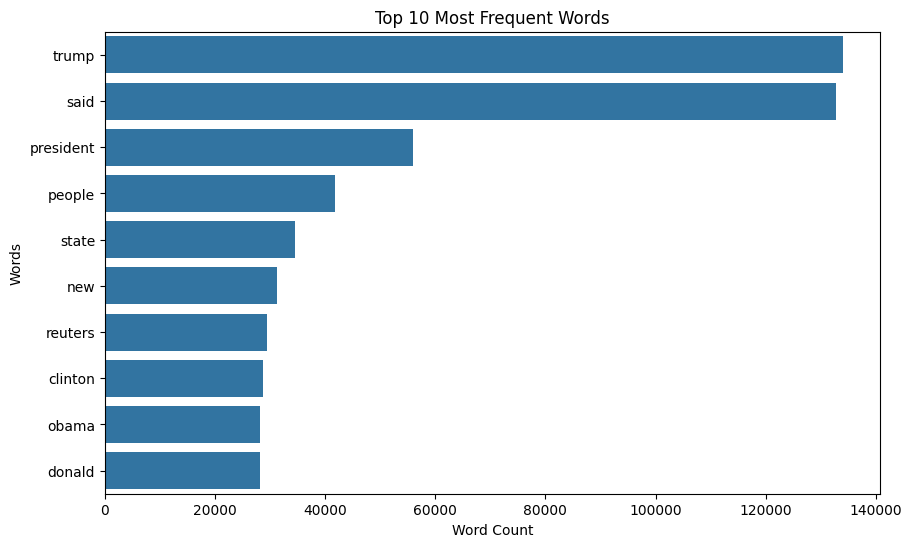

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer to get word counts
count_vec = CountVectorizer(stop_words='english', max_features=10)  # Top 10 words
word_counts = count_vec.fit_transform(fd["text"])

# Sum the word occurrences across all texts
word_counts_sum = np.array(word_counts.sum(axis=0)).flatten()

# Get the vocabulary (words) from the CountVectorizer
words = count_vec.get_feature_names_out()

# Create a DataFrame for easy plotting
word_freq_df = pd.DataFrame({'word': words, 'count': word_counts_sum})

# Plot the top 10 most frequent words
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=word_freq_df.sort_values(by='count', ascending=False))
plt.title('Top 10 Most Frequent Words')
plt.xlabel('Word Count')
plt.ylabel('Words')
plt.show()


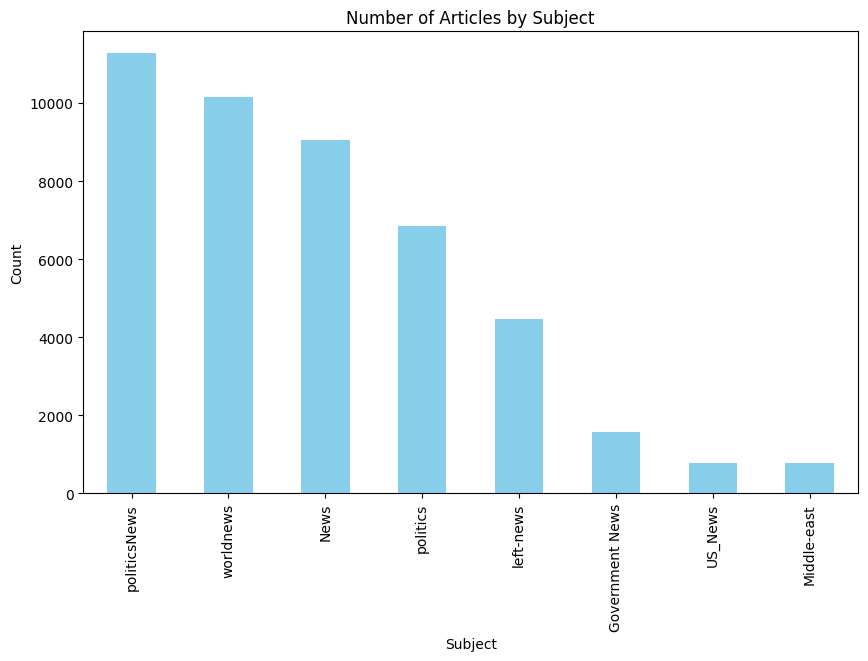

In [17]:
# Bar Plot for Number of Articles by Subject
plt.figure(figsize=(10, 6))
subject_counts = fd_margin['subject'].value_counts()

subject_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Articles by Subject')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


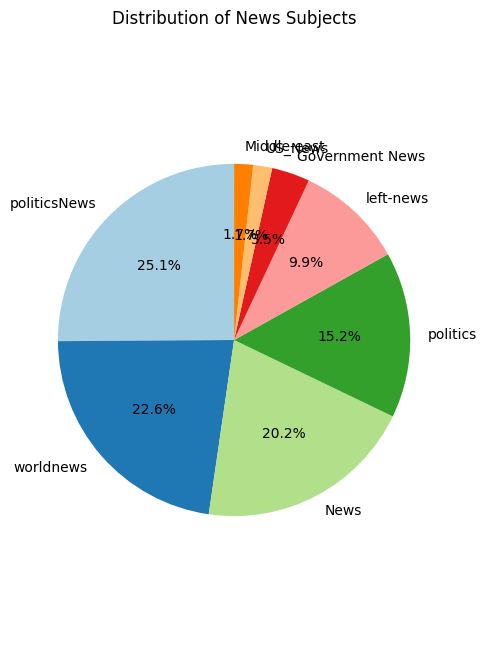

In [21]:
# Count the instances of each subject
subject_counts = fd_margin['subject'].value_counts()

# Labels for the subjects
labels = subject_counts.index

# Plot the pie chart for the distribution of different subjects
plt.figure(figsize=(5, 8))
plt.pie(subject_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of News Subjects')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()



In [23]:
# Vectorize the text data using TF-IDF
vec = TfidfVectorizer(max_features=1000, stop_words='english')
x = vec.fit_transform(fd["text"])

In [24]:
# Optionally reduce the dimensionality of the data using PCA (for 2D visualization)
pca = PCA(n_components=2)
x_reduced = pca.fit_transform(x.toarray())


In [25]:
# Apply KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=0)  # You can try different values of n_clusters
kmeans.fit(x_reduced)


KMeans(n_clusters=2, random_state=0)

In [26]:
# Get the cluster labels
clusters = kmeans.labels_

In [27]:
# Add the cluster labels to the dataframe
fd["cluster"] = clusters

In [28]:
# Display the first few rows of the dataframe with the new cluster labels
print(fd[['text', 'cluster']].head())

                                                text  cluster
0  Donald Trump just couldn t wish all Americans ...        1
1  House Intelligence Committee Chairman Devin Nu...        1
2  On Friday, it was revealed that former Milwauk...        0
3  On Christmas day, Donald Trump announced that ...        1
4  Pope Francis used his annual Christmas Day mes...        0


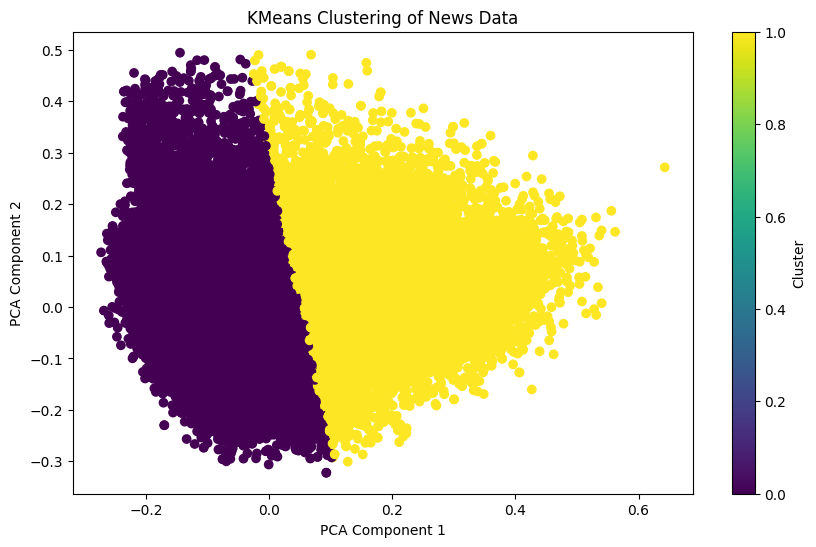

In [29]:

# Visualizing the clusters using the reduced 2D data from PCA
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title("KMeans Clustering of News Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [30]:
# Evaluate the clustering using Silhouette Score
sil_score = silhouette_score(x, clusters)
print(f"Silhouette Score: {sil_score}")


Silhouette Score: 0.01464395226010635
